Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.
Этапы работы:

    1. Преобразуйте данные:
        a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
        b. закодируйте категориальные переменные числовыми значениями по необходимости.
    2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
    3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.
    4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.
    5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
    6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
    7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
    8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.
    9. Сформулируйте выводы по проделанной работе:
        a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
        b. *может ли ROC-кривая проходить ниже диагонали?

*Рекомендации к выполнению:
Убедитесь, что на графике ROC-кривой присутствует диагональная линия, начинающаяся в точке (0;0) и заканчивающаяся в точке (1;1).
Текст оформляйте в отдельной ячейке Jupyter Notebook/Google Colab в формате markdown.
У графиков должен быть заголовок, подписи осей, легенда (опционально). Делайте графики бОльшего размера, чем стандартный вывод, чтобы увеличить читаемость.
Убедитесь, что по ссылкам есть доступ на чтение/просмотр.
Убедитесь, что все ячейки в работе выполнены и можно увидеть их вывод без повторного запуска.


In [61]:
# импорт библиотек
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [62]:
# загрузка данных
df = pd.read_csv('./HW_data/athletes.csv')
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [64]:
# в качестве целевой переменной буду исследовать зависимость получения награды от национальной принадлежности спортсмена и его параметров
# id, имя и дата рождения роли не играют, поэтому эти колонки можно удалить
df1 = df.drop(columns=['id', 'name', 'dob'])
# также создам новую колонку reward, которая показывает получение награды. т.к. один спортсмен может получить несколько наград, то
df1['reward'] = df1[['gold', 'silver', 'bronze']].sum(axis=1)
df2 = df1.drop(columns=['gold', 'silver', 'bronze'])
# преобразую все значения >0 в 1
df2['reward'] = df2['reward'].apply(lambda x: 0 if x == 0 else 1)

In [65]:
# делю данные на X и Y
X = df2[df2.columns[:-1]]
Y = df2['reward']

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nationality  11538 non-null  object 
 1   sex          11538 non-null  object 
 2   height       11208 non-null  float64
 3   weight       10879 non-null  float64
 4   sport        11538 non-null  object 
dtypes: float64(2), object(3)
memory usage: 450.8+ KB


In [67]:
# так как после преобразования категориальных признаков образуется слишком много колонок, сначала заполню пропуски
# заполнять буду медианой, это не совсем правильно с точки зрения чистоты данных, правильнее было бы взять медиану для М и Ж по этой 
# национальности, учитывая второй признак (рост или веc), если он заполнен, но для целей данного задания это было бы избыточным
X.loc[X[X['height'].isna()].index, 'height'] = X['height'].median()
X.loc[X[X['weight'].isna()].index, 'weight'] = X['weight'].median()
X.info() # как видно, пропусков больше нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nationality  11538 non-null  object 
 1   sex          11538 non-null  object 
 2   height       11538 non-null  float64
 3   weight       11538 non-null  float64
 4   sport        11538 non-null  object 
dtypes: float64(2), object(3)
memory usage: 450.8+ KB


In [68]:
Y.describe()

count    11538.000000
mean         0.160946
std          0.367497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: reward, dtype: float64

In [69]:
# преобразую категориальные значения в цифры
X = pd.get_dummies(X, columns=['nationality', 'sport'], dtype=int) # преобразую национальность и вид спорта
X['sex'].replace(['male', 'female'], [0,1], inplace = True) # преобразую пол

In [70]:
# делю данные не тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# создаю и обучаю модель в двух вариантах с нормализацией и без
model = LogisticRegression()
model.fit(X_train, y_train)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

/home/vk/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [71]:
model.score(X_train, y_train)

0.8379148093115404

In [72]:
pipe.score(X_train, y_train)


0.8407627538385339

In [73]:
# считаю предсказание
predict_value = model.predict(X_test)
predict_value

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
# считаю вероятность предсказания
predict_probability = model.predict_proba(X_test)
predict_probability

array([[0.93615716, 0.06384284],
       [0.69521872, 0.30478128],
       [0.67830908, 0.32169092],
       ...,
       [0.64456371, 0.35543629],
       [0.96688332, 0.03311668],
       [0.87121688, 0.12878312]])

In [75]:
predict_probability[:, 1]

array([0.06384284, 0.30478128, 0.32169092, ..., 0.35543629, 0.03311668,
       0.12878312])

In [76]:
# рассчитываю метрики с помощью встроенной функции
fpr_model, tpr_model, tresholds_model = roc_curve(y_test, predict_probability[:, 1], pos_label=1)

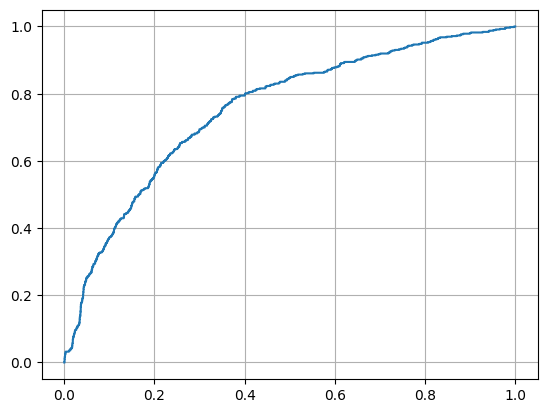

In [77]:
# строю график ROC кривой
plt.plot(fpr_model, tpr_model)
plt.grid()

In [78]:
# вычисляю метрику roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_probability[:, 1])

0.7534639694794786

In [83]:
len(tresholds_model)

846

In [114]:
# вычисляю метрики fpr и tpr вручную
# так как количество автоматически сгенерированных трешхолдов 846, то для ручного вычисления возьму чуть побольше 1000
# пишу функцию, которая по умолчанию принимает на вход посчитанные ранее показатели
treshholds_calc = np.linspace(0, 1, 20)

def roc_curve_calc(y_true=y_test, y_prob=predict_probability[:,1], thresholds = treshholds_calc):

    fpr_calc = []
    tpr_calc = []

    for threshold in thresholds:

        y_pred = np.where(y_prob >= threshold, 1, 0)

        fp = np.sum((y_pred == 1) & (y_true == 0))
        tp = np.sum((y_pred == 1) & (y_true == 1))

        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))

        fpr_calc.append(fp / (fp + tn))
        tpr_calc.append(tp / (tp + fn))

    return [fpr_calc, tpr_calc]
roc_curve_calc()
fpr_calc = roc_curve_calc()[0]
tpr_calc = roc_curve_calc()[1]

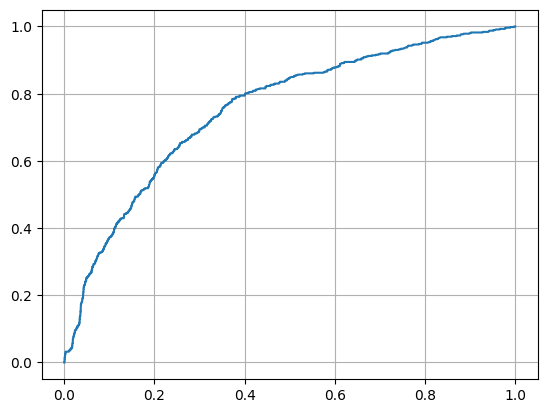

In [110]:
# строю график ROC кривой
plt.plot(fpr_calc, tpr_calc)
plt.grid()

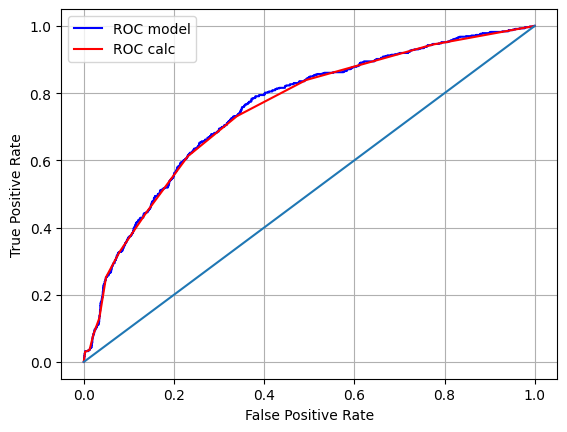

In [116]:
# объединяю графики
# кривые совпадают, однако если указать меньшее количество трешхолдов, то они отличаются
# пример ниже - 846  трешхолдов для модели и 20 для ручного расчёта
# вывод - если на вход поступают примерно одинаковые данные, то и результат будет похожим, независимо от методики рассчёта
plt.plot(fpr_model, tpr_model, label = 'ROC model', c='b')
plt.plot(fpr_calc, tpr_calc, label = 'ROC calc', c='r')
plt.plot([0, 1], [0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=0)
plt.grid()
plt.show()

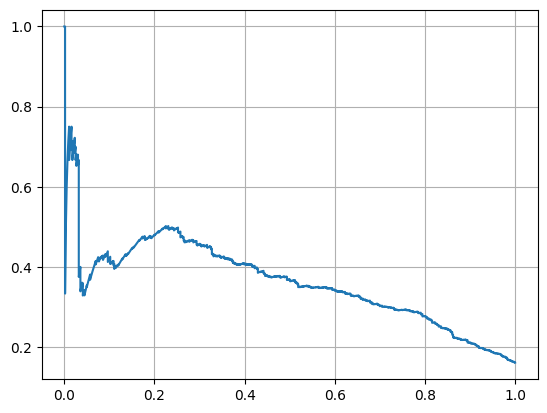

In [118]:
# строю precision-recall curve
from sklearn.metrics import precision_recall_curve
pr, re, thres = precision_recall_curve(y_test, predict_probability[:, 1])
plt.plot(re, pr)
plt.grid()

На основании посчитанных выше метрик и построенных графиков, я бы оценил качество модели как среднее.
Для её практического применения она потребовала бы доработки.

P.S. Сильно отстал от графика, поэтому задания со * не выполнял.